Loaded 58 classes (e.g., ['Airplane', 'Alarm', 'Beep/Bleep']...)
Data split: Train=5761, Val=823, Test=1646
Randomly selected test audio files:
530977
425587

--- Analyzing 530977 ---
          0 | Airplane             |                             0 |   0.0066
          1 | Alarm                |                             0 |   0.0039
          2 | Beep/Bleep           |                             0 |   0.0107
          3 | Bell                 |                             0 |   0.0268
          4 | Bicycle              |                             0 |   0.0011
          5 | Bird Chirp           |                             0 |   0.0050
          6 | Bus                  |                             0 |   0.0012
          7 | Car                  |                             0 |   0.0085
          8 | Cat Meow             |                             0 |   0.0013
          9 | Chainsaw             |                             0 |   0.0005
         10 | Clapping             |

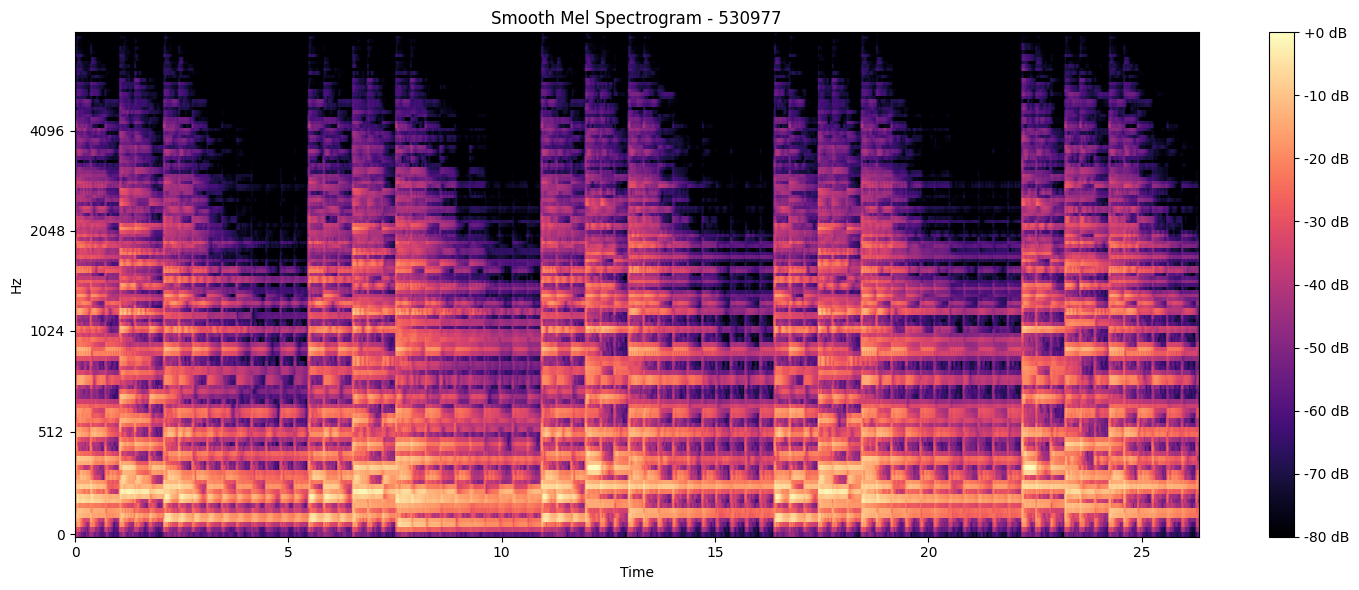

After temporal smoothing:


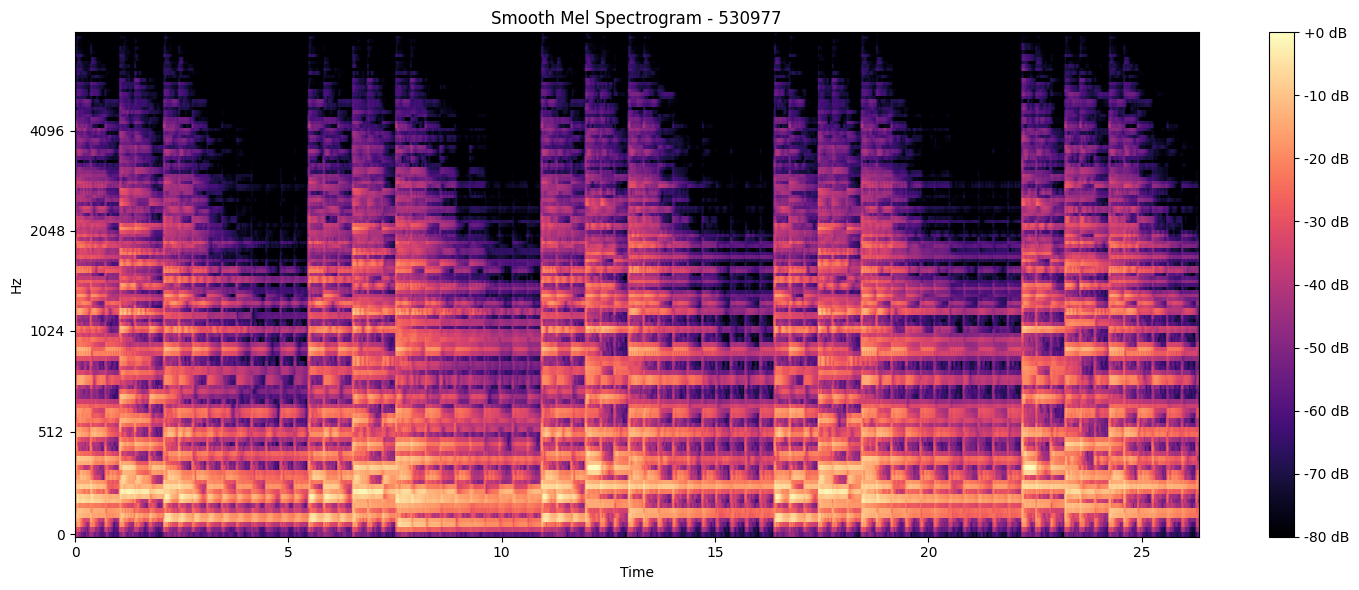

Smoothed predicted class(es): ['Guitar', 'Piano']
Playing audio:
Playing audio at 32000 Hz



--- Analyzing 425587 ---
          0 | Airplane             |                             0 |   0.0007
          1 | Alarm                |                             0 |   0.0024
          2 | Beep/Bleep           |                             0 |   0.0012
          3 | Bell                 |                             0 |   0.0002
          4 | Bicycle              |                             0 |   0.0054
          5 | Bird Chirp           |                             0 |   0.0006
          6 | Bus                  |                             0 |   0.0004
          7 | Car                  |                             0 |   0.0064
          8 | Cat Meow             |                             0 |   0.0003
          9 | Chainsaw             |                           243 |   0.9779
         10 | Clapping             |                             0 |   0.0006
         11 | Cough                |                             0 |   0.0003
         12 | Cow Moo              |  

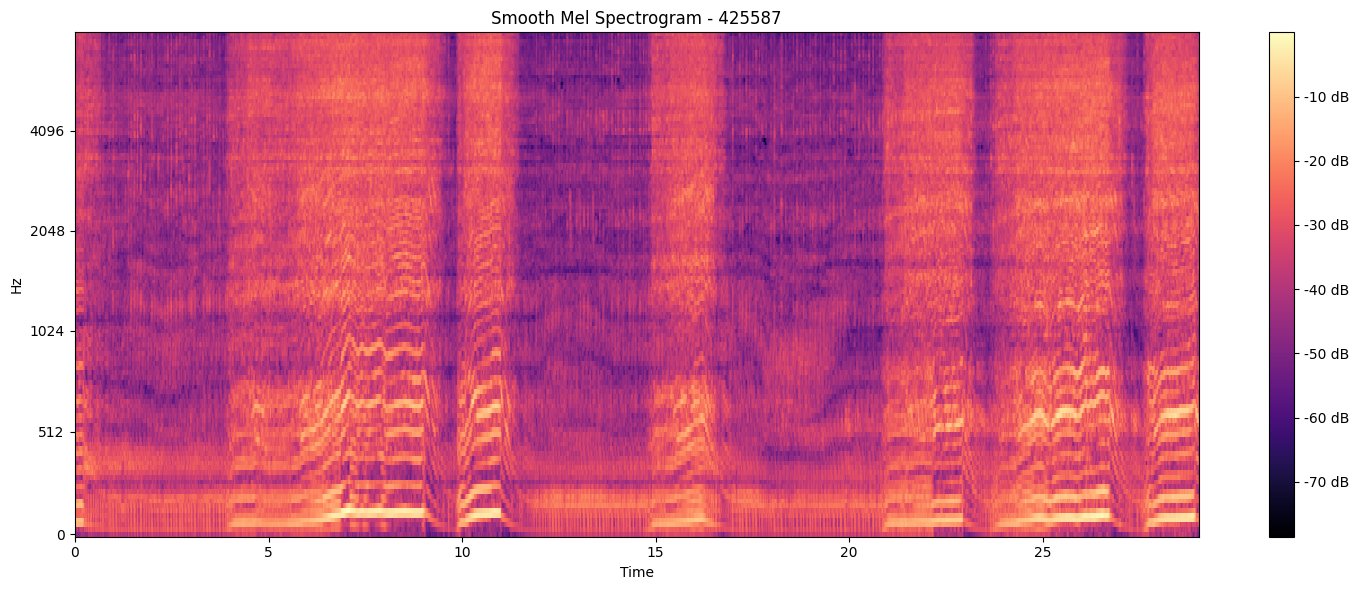

After temporal smoothing:


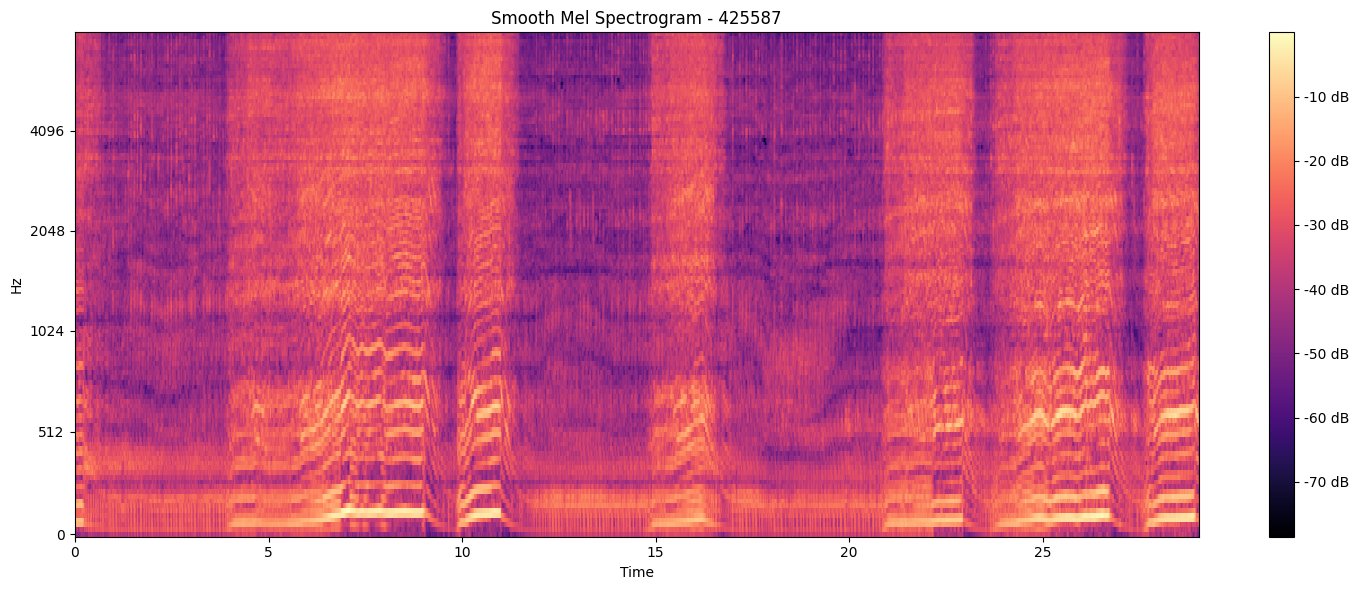

Smoothed predicted class(es): ['Chainsaw']
Playing audio:
Playing audio at 32000 Hz


In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import librosa
import librosa.display
from experiments import CNN1DClassifier, AudioFrameDataset, CLASS_NAMES, EXPECTED_FEATURE_KEYS  # Adjust as needed
from IPython.display import Audio, display
import soundfile as sf
from scipy.ndimage import median_filter
import random
from pathlib import Path
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from typing import List, Tuple

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# --- Your create_data_splits function ---
def create_data_splits(
    file_ids: List[str],
    test_ratio: float = 0.2,
    val_ratio: float = 0.1,
    random_state: int = 42
) -> Tuple[List[str], List[str], List[str]]:
    """Split data into train, validation, and test sets."""
    if not(0 < test_ratio < 1 and 0 < val_ratio < 1 and (test_ratio + val_ratio) < 1):
        raise ValueError("Ratios invalid.")
        
    tv_ids, tst_ids = train_test_split(file_ids, test_size=test_ratio, random_state=random_state)
    rel_val_r = val_ratio / (1.0 - test_ratio)
    trn_ids, val_ids = train_test_split(tv_ids, test_size=rel_val_r, random_state=random_state)
    
    return trn_ids, val_ids, tst_ids
# --- Run model prediction ---
def predict(model, features, device):
    model.eval()
    with torch.no_grad():
        x = torch.from_numpy(features).float().unsqueeze(0).to(device)  # (1, T, F)
        logits = model(x)  # (1, T, C)
        probs = torch.sigmoid(logits).cpu().numpy()[0]  # (T, C)
        preds = (probs > 0.5).astype(int)
    return probs, preds

# --- Plotting ---
def plot_spectrogram_and_predictions(
    file_id, features, preds, labels, class_names, audio_dir, 
    sr=22050, n_fft=2048, hop_length=512, n_mels=128,
    save_path=None
):
    import matplotlib.pyplot as plt

    # Load waveform for smooth mel spectrogram
    audio_path = audio_dir / f"{file_id}.mp3"
    waveform, sr_loaded = librosa.load(audio_path, sr=sr)

    mel_spec = librosa.feature.melspectrogram(
        y=waveform, sr=sr_loaded, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, fmax=8000
    )
    S_dB = librosa.power_to_db(mel_spec, ref=np.max)

    plt.figure(figsize=(15, 6))  # Adjust height as needed

    # Smooth mel spectrogram only
    librosa.display.specshow(
        S_dB, sr=sr_loaded, hop_length=hop_length, x_axis='time', y_axis='mel', 
        fmax=8000, cmap='magma'
    )
    plt.title(f"Smooth Mel Spectrogram - {file_id}")
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()

    plt.savefig(f"{file_id}_plot.png")

    plt.show()




# --- Smoothing ---
def smooth_predictions(preds, kernel_size=7):
    return (median_filter(preds.astype(np.float32), size=(kernel_size, 1)) > 0.5).astype(int)

# --- Audio Playback ---
def play_audio_colab(audio_path):
    try:
        audio_data, sr = librosa.load(audio_path, sr=None)
        print(f"Playing audio at {sr} Hz")
        display(Audio(audio_data, rate=sr))
    except Exception as e:
        print(f"Failed to play audio: {e}")

# --- Load features & labels using dataset class ---
def load_features_labels_from_dataset(dataset, file_id):
    idx = next(i for i, info in enumerate(dataset.processed_file_infos) if info["file_id"] == file_id)
    features, labels = dataset[idx]
    return features.numpy(), labels.numpy()

# --- Setup ---
feature_dir = Path("./audio_features")
label_dir = Path("./labels")
all_label_files = sorted(list(label_dir.glob("*_labels.npz")))
if not all_label_files:
    raise RuntimeError(f"CRITICAL ERROR: No label files found in {LABEL_DIR}")

with np.load(all_label_files[0]) as sf:
    CLASS_NAMES = sorted(list(sf.keys()))

NUM_CLASSES = len(CLASS_NAMES)
if NUM_CLASSES == 0:
    raise RuntimeError(f"CRITICAL ERROR: No classes found in {all_label_files[0]}")

print(f"Loaded {NUM_CLASSES} classes (e.g., {CLASS_NAMES[:min(3, NUM_CLASSES)]}...)")
audio_dir = Path("./audio")
feature_keys = EXPECTED_FEATURE_KEYS
class_names = CLASS_NAMES
input_dim = 942
num_classes = len(class_names)
# Full file list - this should be all available file IDs (strings without extension)
# Example: ['000123', '000124', ...]
FULL_FILE_LIST = [p.stem for p in feature_dir.glob("*.npz")]

# Create data splits (train, val, test)
train_file_ids, val_file_ids, test_file_ids = create_data_splits(
    FULL_FILE_LIST,
    test_ratio=0.2,
    val_ratio=0.1,
    random_state=42
)

print(f"Data split: Train={len(train_file_ids)}, Val={len(val_file_ids)}, Test={len(test_file_ids)}")


# Create test dataset using test_file_ids
test_dataset = AudioFrameDataset(
    feature_dir=feature_dir,
    label_dir=label_dir,
    file_ids=test_file_ids,
    class_names_arg=class_names,
    feature_keys_arg=feature_keys
)

# Randomly sample two audio files from test set
random_test_files = random.sample(test_file_ids, 2)
print("Randomly selected test audio files:")
for f in random_test_files:
    print(f)

# Load model
params = {'cnn_filters_1': 128, 'cnn_filters_2': 128, 'kernel_size': 5, 'dropout_rate': 0.4}
model = CNN1DClassifier(input_dim, num_classes, **params)
checkpoint_path = Path("CNN1D_testBACC_0.8201.pth")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)

# Run analysis on each file
for file_id in random_test_files:
    print(f"\n--- Analyzing {file_id} ---")
    features, labels = load_features_labels_from_dataset(test_dataset, file_id)
    probs, preds = predict(model, features, device)

    threshold = 0.3
    preds_loose = (probs > threshold).astype(int)
    sums = preds_loose.sum(axis=0)
    max_probs = probs.max(axis=0)


    for i, (cls, sum_val, max_val) in enumerate(zip(class_names, sums, max_probs)):
        print(f"{i:11d} | {cls[:20]:20} | {sum_val:29d} | {max_val:8.4f}")

    predicted_classes = [cls for cls, s in zip(class_names, sums) if s > 0]
    print(
        f"\nPredicted classes at threshold {threshold}: {predicted_classes if predicted_classes else 'None detected'}")

    threshold = 0.3
    preds = (probs > threshold).astype(int)
    sum_over_time = preds.sum(axis=0)

    print(f"Any class > {threshold}? {np.any(probs > threshold)}")
    print(f"Sum over time of preds per class: {sum_over_time}")

    predicted_classes = [cls for cls, s in zip(class_names, sum_over_time) if s > 0]
    if predicted_classes:
        print("Predicted classes:", predicted_classes)
    else:
        print("None detected")

    plot_spectrogram_and_predictions(file_id, features, preds, labels, class_names, audio_dir)

    preds_smooth = smooth_predictions(preds, kernel_size=7)
    print("After temporal smoothing:")
    plot_spectrogram_and_predictions(file_id, features, preds_smooth, labels, class_names, audio_dir)

    # Print smoothed class names
    smooth_presence = preds_smooth.sum(axis=0) > 0
    smoothed_classes = [cls for cls, present in zip(class_names, smooth_presence) if present]
    print("Smoothed predicted class(es):", smoothed_classes if smoothed_classes else "None detected")

    print("Playing audio:")
    play_audio_colab(audio_dir / f"{file_id}.mp3")